# 6.0002 Lecture 5: Random Walks

**Speaker:** Prof. John Guttag

## Why random walks?
- random walks are important in many domains
    - understanding the stock market (maybe)
    - modeling diffusion processes
    - etc.
- good illustration of how to use simulations to understand things
- excuse to cover some important programming topics
    - practice with classes
    - practice with plotting

## Drunkard's walk
- each time step, he takes a step in either: north, west, east, or south direction
- confined to a discrete spatial grid (lattice)

## Expected distance after 100,000 steps?
- too many individual cases to consider
- need a different approach to problem
- will use simulation

## Structure of simulation
- simulate one walk of k steps
- simulate n such walks
- report average distance from origin

## first, some useful abstractions
- location - a place
- field - a collection of places and drunks
- drunk - somebody who wanders from place to place in a field

## Class Location

In [1]:
class Location(object):
    def __init__(self, x, y):
        """x and y are floats"""
        self.x = x
        self.y = y
        
    def move(self, deltaX, deltaY):
        """deltaX and deltaY are floats"""
        return Location(self.x + deltaX, self.y + deltaY)
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    
    def distFrom(self, other):
        xDist = self.x - other.getX()
        yDist = self.y - other.getY()
        return (xDist**2 + yDist**2)**0.5
    
    def __str__(self):
        return '<' + str(self.x) + ', ' + str(self.y) + '>'

## Class Drunk

In [2]:
class Drunk(object):
    def __init__(self, name=None):
        """Assumes name is a str"""
        self.name = name
    
    def __str__(self):
        if self != None:
            return self.name
        return 'Anonymous'

- the above class not intended to be useful on its own
- a base class to be inherited

## Two subclasses of Drunk
- the "usual" drunk, who wanders around at random
- the "masochistic" drunk, who tries to move northward
    - a.k.a. a New England-er

In [3]:
import random

class UsualDrunk(Drunk):
    def takeStep(self):
        stepChoices = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        return random.choice(stepChoices)

class MasochisticDrunk(Drunk):
    # biased random walk: goes more north than south
    def takeStep(self):
        stepChoices = [(0.0, 1.1), (0.0, -0.9), (1.0, 0.0), (-1.0, 0.0)]
        return random.choice(stepChoices)

- are drunks mutable or immutable?
    - nothing is getting changed... 
    - the drunk gets greated, and then returns the step

## Class Field

In [4]:
class Field(object):
    def __init__(self):
        self.drunks = {}
    
    def addDrunk(self, drunk, loc):
        if drunk in self.drunks:
            raise ValueError('Duplicate drunk')
        else:
            self.drunks[drunk] = loc
    
    def getLoc(self, drunk):
        if drunk not in self.drunks:
            raise ValueError('Drunk not in field')
        return self.drunks[drunk]
    
    def moveDrunk(self, drunk):
        if drunk not in self.drunks:
            raise ValueError('Drunk not in field')
        xDist, yDist = drunk.takeStep()
        # use move method of Location to get new location
        self.drunks[drunk] = self.drunks[drunk].move(xDist, yDist)

- this is mutable, because the dict is being changed when location moves

## Simulating a single walk

In [5]:
def walk(f, d, numSteps):
    """ Assumes: f a Field, d a Drunk in f, and 
        numSteps an int >= 0.
        Moves d numSteps times; returns the distance
        between the final location and the location
        at the start of the walk. """
    start = f.getLoc(d)
    for s in range(numSteps):
        f.moveDrunk(d)
    return start.distFrom(f.getLoc(d))

## Simulating multiple walks

In [6]:
def simWalks(numSteps, numTrials, dClass):
    """ Assumes numSteps an int >= 0, numTrials an
        int > 0, dClass a subclass of Drunk
        Simulates numTrials walks of numSteps steps
        each. Returns a list of the final distances
        for each trial. """
    Homer = dClass()
    origin = Location(0,0)
    distances = []
    for t in range(numTrials):
        f = Field()
        f.addDrunk(Homer, origin)
        distances.append(round(walk(f, Homer, 
                                    numTrials), 1))
    return distances

## Putting it all together

In [7]:
def drunkTest(walkLengths, numTrials, dClass):
    """Assumes walkLengths a sequence of ints >= 0
        numTrials an int > 0,
        dClass a subclass of Drunk   
       For eacn number of steps in walkLengths,
        run simWalks with numTrials walks and
        prints results
        """
    for numSteps in walkLengths:
        distances = simWalks(numSteps, numTrials, 
                             dClass)
        print(dClass.__name__, 'random walk of', 
              numSteps, 'steps')
        print(' Mean =', 
              round(sum(distances)/len(distances), 4))
        print(' Max =', max(distances), 
             'Min =', min(distances))

## Let's try it

In [8]:
drunkTest((10, 100, 1000, 10000), 100, UsualDrunk)

UsualDrunk random walk of 10 steps
 Mean = 8.917
 Max = 23.0 Min = 0.0
UsualDrunk random walk of 100 steps
 Mean = 8.703
 Max = 22.8 Min = 1.4
UsualDrunk random walk of 1000 steps
 Mean = 8.643
 Max = 24.0 Min = 0.0
UsualDrunk random walk of 10000 steps
 Mean = 9.054
 Max = 23.4 Min = 0.0


- how plausible is this?
- seems number of steps not affecting average distance

## Let's try a sanity check
- try on cases where we think we know the answer
    - a very important precaution

## Sanity Check

In [9]:
drunkTest((0, 1, 2), 100, UsualDrunk)

UsualDrunk random walk of 0 steps
 Mean = 8.439
 Max = 18.4 Min = 0.0
UsualDrunk random walk of 1 steps
 Mean = 8.968
 Max = 20.2 Min = 1.4
UsualDrunk random walk of 2 steps
 Mean = 9.287
 Max = 24.7 Min = 0.0


- this seems suspicious... for 0, 1, and 2 steps, we get roughly the same numbers as before
- look at code
    - what we were appending was:
        - distances.append(round(walk(f, Homer, numTrials), 1))
    -  bug! we meant to use numSteps, not numTrials.
    - so we were getting the same numbers because we were callign *walk* with a constant, namely numTrials (100)

## fix the code

In [10]:
def simWalks(numSteps, numTrials, dClass):
    """ Assumes numSteps an int >= 0, numTrials an
        int > 0, dClass a subclass of Drunk
        Simulates numTrials walks of numSteps steps
        each. Returns a list of the final distances
        for each trial. """
    Homer = dClass()
    origin = Location(0,0)
    distances = []
    for t in range(numTrials):
        f = Field()
        f.addDrunk(Homer, origin)
        distances.append(round(walk(f, Homer, 
                                    numSteps), 1)) # numSteps, NOT numTrials
    return distances

def drunkTest(walkLengths, numTrials, dClass):
    """Assumes walkLengths a sequence of ints >= 0
        numTrials an int > 0,
        dClass a subclass of Drunk   
       For eacn number of steps in walkLengths,
        run simWalks with numTrials walks and
        prints results
        """
    for numSteps in walkLengths:
        distances = simWalks(numSteps, numTrials, 
                             dClass)
        print(dClass.__name__, 'random walk of', 
              numSteps, 'steps')
        print(' Mean =', 
              round(sum(distances)/len(distances), 4))
        print(' Max =', max(distances), 
             'Min =', min(distances))

## Let's try it

In [11]:
drunkTest((10, 100, 1000, 10000), 100, UsualDrunk)

UsualDrunk random walk of 10 steps
 Mean = 2.921
 Max = 7.6 Min = 0.0
UsualDrunk random walk of 100 steps
 Mean = 9.659
 Max = 25.5 Min = 0.0
UsualDrunk random walk of 1000 steps
 Mean = 29.718
 Max = 75.8 Min = 4.0
UsualDrunk random walk of 10000 steps
 Mean = 81.967
 Max = 240.2 Min = 13.0


In [12]:
# sanity check
drunkTest((0, 1, 2), 100, UsualDrunk)

UsualDrunk random walk of 0 steps
 Mean = 0.0
 Max = 0.0 Min = 0.0
UsualDrunk random walk of 1 steps
 Mean = 1.0
 Max = 1.0 Min = 1.0
UsualDrunk random walk of 2 steps
 Mean = 1.152
 Max = 2.0 Min = 0.0


- makes more sense! 
- doesn't mean simulation is necessarily right, but we at least passed sanity check

## and the Masochistic Drunk?

In [14]:
def simAll(drunkKinds, walkLengths, numTrials):
    for dClass in drunkKinds:
        drunkTest(walkLengths, numTrials, dClass)

In [15]:
random.seed(0)
simAll((UsualDrunk, MasochisticDrunk), (1000, 10000), 100)

UsualDrunk random walk of 1000 steps
 Mean = 26.828
 Max = 66.3 Min = 4.2
UsualDrunk random walk of 10000 steps
 Mean = 90.073
 Max = 210.6 Min = 7.2
MasochisticDrunk random walk of 1000 steps
 Mean = 58.425
 Max = 133.3 Min = 6.7
MasochisticDrunk random walk of 10000 steps
 Mean = 515.575
 Max = 694.6 Min = 377.7


- masochistic drunk seems to be making considerably more progress than the usual drunk
    - bias is affecting average distances
    - why?

## Visualizing the trend
- simulate walks of multiple lengths for each kind of drunk
- plot distance at end of each length walk for each kind of drunk

## Pylab
- **NumPy** adds vectors, matrices, and many high-level mathematical functions
- **SciPy** adds mathematical classes and functions useful to scientists
- **MatPlotLib** adds an object-oriented API for plotting
- **PyLab** combines the other libraries to provide a MATLAB-like interface

## plot
- the first two arguments to *pylab.plot* must be sequences of the same length
- first argument gives x-coordinates
- second argument gives y-coordinates
- many optional arguments
- points plotted in order. In default style, as each point is plotted, a line is drawn connecting it to the previous point

## Example

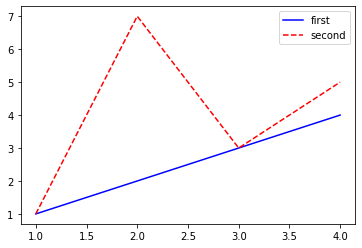

In [17]:
import pylab

xVals = [1, 2, 3, 4]
yVals1 = [1, 2, 3, 4]
pylab.plot(xVals, yVals1, 'b-', label='first')
yVals2 = [1, 7, 3, 5]
pylab.plot(xVals, yVals2, 'r--', label='second')
pylab.legend()

## Details and many more examples
- assigned reading
- video of Prof. Grimson's lecture from 6.00x.1
- code for this lecture
- matplotlib.org/api/pyplot_summary.html
- www.scipy.org/Plotting_Tutorial

## Distance Trends

In [18]:
class styleIterator(object):
    def __init__(self, styles):
        self.index = 0
        self.styles = styles

    def nextStyle(self):
        result = self.styles[self.index]
        if self.index == len(self.styles) - 1:
            self.index = 0
        else:
            self.index += 1
        return result

In [19]:
def simDrunk(numTrials, dClass, walkLengths):
    meanDistances = []
    for numSteps in walkLengths:
        print('Starting simulation of',
              numSteps, 'steps')
        trials = simWalks(numSteps, numTrials, dClass)
        mean = sum(trials)/len(trials)
        meanDistances.append(mean)
    return meanDistances

def simAll(drunkKinds, walkLengths, numTrials):
    styleChoice = styleIterator(('m-', 'b--', 'g-.'))
    for dClass in drunkKinds:
        curStyle = styleChoice.nextStyle()
        print('Starting simulation of', dClass.__name__)
        means = simDrunk(numTrials, dClass, walkLengths)
        pylab.plot(walkLengths, means, curStyle,
                   label = dClass.__name__)
    pylab.title('Mean Distance from Origin ('
                + str(numTrials) + ' trials)')
    pylab.xlabel('Number of Steps')
    pylab.ylabel('Distance from Origin')
    pylab.legend(loc = 'best')

Starting simulation of UsualDrunk
Starting simulation of 10 steps
Starting simulation of 100 steps
Starting simulation of 1000 steps
Starting simulation of 10000 steps
Starting simulation of MasochisticDrunk
Starting simulation of 10 steps
Starting simulation of 100 steps
Starting simulation of 1000 steps
Starting simulation of 10000 steps


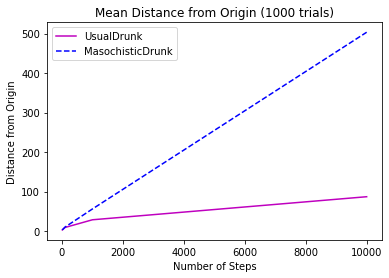

In [28]:
random.seed(0)
simAll((UsualDrunk, MasochisticDrunk), (10, 100, 1000, 10000), 1000)

## Ending Locations

In [20]:
def getFinalLocs(numSteps, numTrials, dClass):
    locs = []
    d = dClass()
    for t in range(numTrials):
        f = OddField()
        f.addDrunk(d, Location(0, 0))
        for s in range(numSteps):
            f.moveDrunk(d)
        locs.append(f.getLoc(d))
    return locs

def plotLocs(drunkKinds, numSteps, numTrials):
    styleChoice = styleIterator(('k+', 'r^', 'mo'))
    for dClass in drunkKinds:
        locs = getFinalLocs(numSteps, numTrials, dClass)
        xVals, yVals = [], []
        for loc in locs:
            xVals.append(loc.getX())
            yVals.append(loc.getY())
        xVals = pylab.array(xVals)
        yVals = pylab.array(yVals)
        meanX = sum(abs(xVals))/len(xVals)
        meanY = sum(abs(yVals))/len(yVals)
        curStyle = styleChoice.nextStyle()
        pylab.plot(xVals, yVals, curStyle,
                      label = dClass.__name__ +\
                      ' mean abs dist = <'
                      + str(meanX) + ', ' + str(meanY) + '>')
    pylab.title('Location at End of Walks ('
                + str(numSteps) + ' steps)')
    pylab.ylim(-1000, 1000)
    pylab.xlim(-1000, 1000)
    pylab.xlabel('Steps East/West of Origin')
    pylab.ylabel('Steps North/South of Origin')
    pylab.legend(loc = 'lower center')

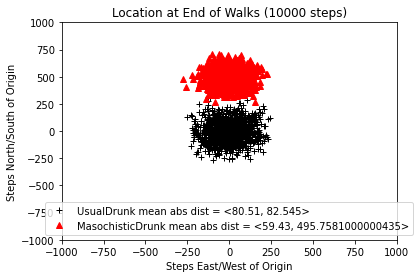

In [24]:
random.seed(0)
plotLocs((UsualDrunk, MasochisticDrunk), 10000, 1000)

## Fields with wormholes

In [23]:
# subclass of field
class OddField(Field):
    def __init__(self, numHoles = 1000,
                 xRange = 100, yRange = 100):
        Field.__init__(self)
        self.wormholes = {}
        for w in range(numHoles):
            x = random.randint(-xRange, xRange)
            y = random.randint(-yRange, yRange)
            newX = random.randint(-xRange, xRange)
            newY = random.randint(-yRange, yRange)
            newLoc = Location(newX, newY)
            self.wormholes[(x, y)] = newLoc

    def moveDrunk(self, drunk):
        Field.moveDrunk(self, drunk)
        x = self.drunks[drunk].getX()
        y = self.drunks[drunk].getY()
        if (x, y) in self.wormholes:
            self.drunks[drunk] = self.wormholes[(x, y)]

In [25]:
#TraceWalk using oddField          
def traceWalk(fieldKinds, numSteps):
    styleChoice = styleIterator(('b+', 'r^', 'ko'))
    for fClass in fieldKinds:
        d = UsualDrunk()
        f = fClass()
        f.addDrunk(d, Location(0, 0))
        locs = []
        for s in range(numSteps):
            f.moveDrunk(d)
            locs.append(f.getLoc(d))
        xVals, yVals = [], []
        for loc in locs:
            xVals.append(loc.getX())
            yVals.append(loc.getY())
        curStyle = styleChoice.nextStyle()
        pylab.plot(xVals, yVals, curStyle,
                   label = fClass.__name__)
    pylab.title('Spots Visited on Walk ('
                + str(numSteps) + ' steps)')
    pylab.xlabel('Steps East/West of Origin')
    pylab.ylabel('Steps North/South of Origin')
    pylab.legend(loc = 'best')

## Spots reached during one walk

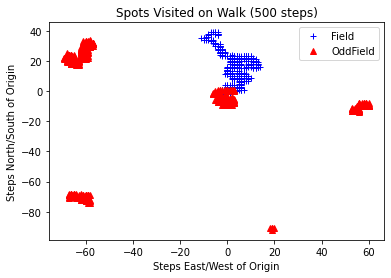

In [26]:
random.seed(0)
traceWalk((Field, OddField), 500)

## Summary
- point is not the simulation themselves, but how we built them
- started by defining classes
- build functions corresponding to
    - one trial, multiple trials, result reporting
- made series of incremental changes to simulation so that we could investigate different questions
    - get simple version working first
    - did a sanity check!
    - elaborate a step at a time
- showed how to use plots to get insights